In [1]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

# fundamental constants
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

In [60]:
# parameters

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc #1e2*meV
mu_sc=0*hwc #1e2*meV
D1=0.*hwc #10*meV
D2=0.*hwc #10*meV
nu=0#sqrt(2)+0.1
mu_n=nu*hwc #10*meV
m_n=0.1*hwc

lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc
# lam=0.5*vF
gs=0.0*hwc
gn=0.3*hwc

Ls=8*lB
Lx=8*lB

In [2]:
# new parameters

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc #1e2*meV
mu_sc=0*hwc #1e2*meV
D1=0.02*hwc #10*meV
D2=0.02*hwc #10*meV
nu=0.0#sqrt(2)+0.1
mu_n=nu*hwc #10*meV
m_n=0.001*hwc

lRx= 0.1*hwc
print(lRx/hwc)
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.003*hwc

Ls=10*lB
Lx=14*lB

0.09999999999999999


In [45]:
# newest parameters

vF=1e6
B=6 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc #1e2*meV
mu_sc=0*hwc #1e2*meV
D1=0.3*hwc #10*meV
D2=0.2*hwc #10*meV
m_n=0.06*hwc

lRx= 0.2*hwc
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.2*hwc
nu=0.45
mu_n=nu*hwc #10*meV


Ls=6*lB
Lx=8*lB

In [46]:
ky_sw=np.linspace(-4,4,201)*1/lB
Nx=100
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

Hx= hbar*vF*np.kron(sigma3, np.kron(np.diag(kx) , sigma1))
HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma2)

Hxm= np.kron( m_sc*y0s(k1-k2)+2*m_n*np.real(y0(k1-k2)) , sigma3)

Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )

Vn=np.zeros((4*Nx,4*Nx,len(ky_sw)), dtype=np.complex64)
En=np.zeros((4*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)

    H_t = Hx + np.kron(sigma0, Hy+ HeB + Hxm + Hef)
    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)


print("Done!")

Done!


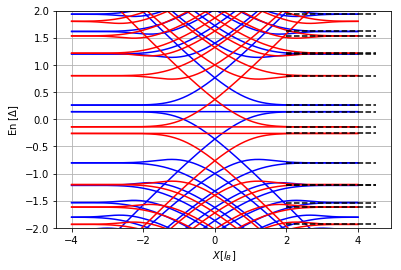

In [36]:
plt.figure()
plt.plot(ky_sw*lB,En.T/hwc+gn/hwc,'b')
plt.plot(ky_sw*lB,En.T/hwc-gn/hwc,'r')
# plt.plot(ky_sw*lB,En[:199,:].T/hwc+gn/hwc,'b')
# plt.plot(ky_sw*lB,En[201:,:].T/hwc+gn/hwc,'b')
# plt.plot(ky_sw*lB,En[:199,:].T/hwc-gn/hwc,'r')
# plt.plot(ky_sw*lB,En[201:,:].T/hwc-gn/hwc,'r')
plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")

Nll=4
ill=np.arange(Nll)
E1=np.reshape(np.sqrt(ill+(m_n/hwc)**2),[1,Nll])
Eplot= np.concatenate((E1,E1),axis=0)
xvals=np.reshape(np.array([2,4.5]),[2,1])
plt.plot(xvals, Eplot-mu_n/hwc-gn/hwc,'k--')
plt.plot(xvals, Eplot-mu_n/hwc+gn/hwc,'k--')
plt.plot(xvals, -Eplot+mu_n/hwc-gn/hwc,'k--')
plt.plot(xvals, -Eplot+mu_n/hwc+gn/hwc,'k--')


# plt.ylim(-22,22)
# plt.ylim(-0.015,0.015)
plt.ylim(-2,2)
plt.grid()

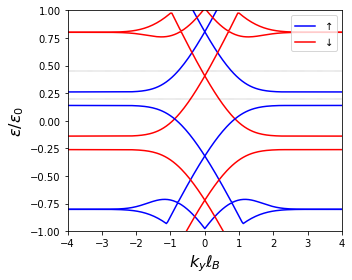

In [50]:
######### plot for the notes

ix=4

plt.figure(figsize=(5,4))
plt.plot(ky_sw*lB,En[2*Nx+1,:].T/hwc+gn/hwc+nu,'b',label=r'$\uparrow$')
plt.plot(ky_sw*lB,En[2*Nx+1,:].T/hwc-gn/hwc+nu,'r',label=r'$\downarrow$')
plt.plot(ky_sw*lB,En[2*Nx-ix:2*Nx-1,:].T/hwc+gn/hwc+nu,'b')
plt.plot(ky_sw*lB,En[2*Nx+2:2*Nx+ix,:].T/hwc+gn/hwc+nu,'b')
plt.plot(ky_sw*lB,En[2*Nx-ix:2*Nx-1,:].T/hwc-gn/hwc+nu,'r')
plt.plot(ky_sw*lB,En[2*Nx+2:2*Nx+ix,:].T/hwc-gn/hwc+nu,'r')
lw=0.2
plt.plot(2*ky_sw*lB,ky_sw*0+0.2,'k--',linewidth=lw)
plt.plot(2*ky_sw*lB,ky_sw*0+0.45,'k--',linewidth=lw)
fsize=16
plt.ylabel(r"$\varepsilon/\varepsilon_0$",fontsize = fsize)
plt.xlabel(r"$k_y \ell_B$",fontsize = fsize)
plt.ylim(-1,1)
plt.xlim(-4.,4.)
# plt.xlim(-1,4)
# plt.xticks(np.arange(-4,4.1,2))
# plt.yticks(np.arange(-2,2.1,1))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('figs/LLbands_B_%d.pdf' % (B))
plt.show()

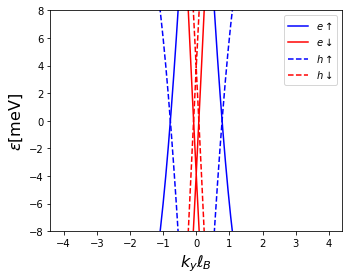

In [47]:
######### plot for the paper in meV

ix=4

plt.figure(figsize=(5,4))
plt.plot(ky_sw*lB,En[2*Nx+1,:].T/elec*1e3+gn/elec*1e3,'b',label=r'$e\uparrow$')
plt.plot(ky_sw*lB,En[2*Nx+1,:].T/elec*1e3-gn/elec*1e3,'r',label=r'$e\downarrow$')
plt.plot(ky_sw*lB,En[2*Nx-ix:2*Nx-1,:].T/elec*1e3+gn/elec*1e3,'b')
plt.plot(ky_sw*lB,En[2*Nx+2:2*Nx+ix,:].T/elec*1e3+gn/elec*1e3,'b')
plt.plot(ky_sw*lB,En[2*Nx-ix:2*Nx-1,:].T/elec*1e3-gn/elec*1e3,'r')
plt.plot(ky_sw*lB,En[2*Nx+2:2*Nx+ix,:].T/elec*1e3-gn/elec*1e3,'r')

plt.plot(ky_sw*lB,-(En[2*Nx+1,:].T/elec*1e3+gn/elec*1e3),'b--',label=r'$h\uparrow$')
plt.plot(ky_sw*lB,-(En[2*Nx+1,:].T/elec*1e3-gn/elec*1e3),'r--',label=r'$h\downarrow$')
plt.plot(ky_sw*lB,-(En[2*Nx-ix:2*Nx-1,:].T/elec*1e3+gn/elec*1e3),'b--')
plt.plot(ky_sw*lB,-(En[2*Nx+2:2*Nx+ix,:].T/elec*1e3+gn/elec*1e3),'b--')
plt.plot(ky_sw*lB,-(En[2*Nx-ix:2*Nx-1,:].T/elec*1e3-gn/elec*1e3),'r--')
plt.plot(ky_sw*lB,-(En[2*Nx+2:2*Nx+ix,:].T/elec*1e3-gn/elec*1e3),'r--')

lw=0.2
# plt.plot(2*ky_sw*lB,ky_sw*0+0.2*hwc/elec*1e3,'k--',linewidth=lw)
# plt.plot(2*ky_sw*lB,ky_sw*0+0.45*hwc/elec*1e3,'k--',linewidth=lw)
fsize=16
# plt.ylabel(r"$\varepsilon/\varepsilon_0$",fontsize = fsize)
plt.ylabel(r"$\varepsilon$[meV]",fontsize = fsize)
plt.xlabel(r"$k_y \ell_B$",fontsize = fsize)
plt.ylim(-8,8)
# plt.xlim(-4.4,4.4)
# plt.xlim(-1,4)
# plt.xticks(np.arange(-4,4.1,2))
# plt.yticks(np.arange(-2,2.1,1))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('figs/vacuum_mun_%.2f.pdf' % (nu))
# plt.savefig('figs/TS_Hoppe_particle_m_n.pdf')
plt.show()

In [25]:
def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p_K1 = ev[:2*Nx,:]
    ev_p_K2 = ev[2*Nx:,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])
           

def plot_wf(i_band=Nx,iwf=int(len(ky_sw)/2)):
# iwf=0
    plt.figure(figsize=(10,5))
    plt.subplot(3,2,1)
    plt.plot(ky_sw*lB,En.T/hwc,'b')
    plt.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    plt.ylabel("Energy(meV)")
    plt.xlabel("X(l)")
    plt.ylim(-0.2,1.6)
    # plt.xlim(-7.5,7.5)
    plt.grid()
#     plt.show()

    x0=np.linspace(-1,1,500)*12*lB
    wfpK1_uA,wfpK1_uB,\
    wfpK2_uA,wfpK2_uB,\
    =wf_real_space(np.reshape(Vn[:,i_band,:],[4*Nx,len(ky_sw)]),kx,x0,Ls)
#     plt.figure()
    plt.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    plt.subplot(2,2,3)
    plt.title('K1')
    plt.plot(x0/lB,np.abs(wfpK1_uA[:,iwf])**2,label=r'$eA\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK1_uB[:,iwf])**2,label=r'$eB\uparrow$')

    plt.legend()
    plt.subplot(2,2,4)
    plt.title('K2')
    plt.plot(x0/lB,np.abs(wfpK2_uA[:,iwf])**2,label=r'$eA\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK2_uB[:,iwf])**2,label=r'$eB\uparrow$')

    plt.legend()

    plt.show()

interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(2*Nx-int(nu**2)-5,2*Nx+int(nu**2)+5));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', options=(195, 196, 197, 198, 199, 200, 201, 202, 203, 204…

SC spectrum

In [58]:
lB

8.100925873009825e-09